# This code uses the new discrete code

In [1]:
import os
import sys
import collections
import tensorflow as tf
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)

## PLOTTING 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting


### IMPORT FROM CURRENT PROJECT
import progress_learner
import config
import project
from project import Project

### RL module
from rl import action_learner, action_learner_search, value_estimator
from rl import block_movement_env
from rl import discrete_value_estimator as  dve
from rl import discrete_action_learner as dal

C:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [56]:
reload(dal)
dal._test_get_action_from_quantized_states()

The action from (2, 1) to (1, 0) is illegal
The action 2 from (2, 1) to (2, 0)
The action from (2, 1) to (3, 0) is illegal
The action 3 from (2, 1) to (1, 1)
The action 0 from (2, 1) to (2, 1)
The action 1 from (2, 1) to (3, 1)
The action from (2, 1) to (1, 2) is illegal
The action 4 from (2, 1) to (2, 2)
The action from (2, 1) to (3, 2) is illegal


In [57]:
dal._test_realize_action()

quantized (2, 1.0)
prev (2, 1.0)
cur (2, 1.0)
action [0.65355339 0.75355339 0.        ]
requantized (2, 1.0)
prev (2, 1.0)
cur (3, 1.0)
action [1.00710678 1.10710678 0.        ]
requantized (3, 1.0)
prev (2, 1.0)
cur (2, 0.0)
action [0.8 0.4 0. ]
requantized (2, 0.0)
prev (2, 1.0)
cur (1, 1.0)
action [0.4767767 0.5767767 0.       ]
requantized (1, 1.0)
prev (2, 1.0)
cur (2, 2.0)
action [0.3 0.9 0. ]
requantized (2, 2.0)


In [83]:
### RELOAD modules here
reload(config)
reload(value_estimator)
reload(config)
reload(block_movement_env)
reload(action_learner_search)
reload(progress_learner)
reload(dal)
reload(dve)


### MAIN CODE
tf.reset_default_graph()

c = config.Qual_Plan_Config()
c.num_episodes = 10

global_step = tf.Variable(0, name="global_step", trainable=False)


policy_est = dve.DiscretePolicyEstimator(c)
value_est = dve.ValueEstimator(c)

sess =  tf.Session()

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

# action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]
action_types = ["SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load(os.path.join('..' , 'learned_models', p_name))

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training=True, name = projects[project_name].name, config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, os.path.join('..' , 'learned_models', 'progress_' + project_name + '.mod.1'))

Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/Variable:0
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
model/SlideAround/beta1_power:0
model/SlideAround/beta2_power:0
model/SlideAround/model/SlideAround/linear/weight/Adam:0
model/SlideAround/model/SlideAround/linear/weight/Adam_1:0
model/SlideAround/model/SlideAround/linear/bias/Adam:0
model/SlideAround/model/SlideAround/linear/bias/Adam_1:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/Adam:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/

In [96]:
reload(dal)
c.num_episodes = 1
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 10)

past_envs, stats = action_ln.policy_learn(dal.random_action, breadth = 1, verbose = True,
                                          choice = 'ACTOR_CRITIC', default = False)

2 0 0.0 50
action_probs [0.23333232 0.19673884 0.1654991  0.21994564 0.18448411]
action = (array([0.13462969, 0.12740303, 0.30702688]), 0.002769321436062455)
best reward = 0.00
0 0 0.0 0
best_action = (3, array([0.13462969, 0.12740303, 0.30702688]), 0.007530162576586008, False)
Step 0 @ Episode 1/1 (0.007530162576586008)
td_target = 0.08, predicted_target = 0.03, advantage = 0.05
action_probs [0.22999232 0.18347546 0.22536343 0.18104073 0.18012811]
action = (array([-0.29287061,  0.54820993,  0.30702688]), 0.6366757)
best reward = 0.64
5 1 0.0 130
best_action = (2, array([-0.29287061,  0.54820993,  0.30702688]), 0.70018524, False)
Step 1 @ Episode 1/1 (0.707715401891619)
td_target = 0.75, predicted_target = 0.07, advantage = 0.68
action_probs [0.20661412 0.2343257  0.17656529 0.20609659 0.17639829]
action = (array([-0.07093415,  0.43312646,  0.30702688]), -0.24613672)
best reward = -0.25
4 0 3.0 103
best_action = (0, array([-0.07093415,  0.43312646,  0.30702688]), -0.2794191, False)
Ste

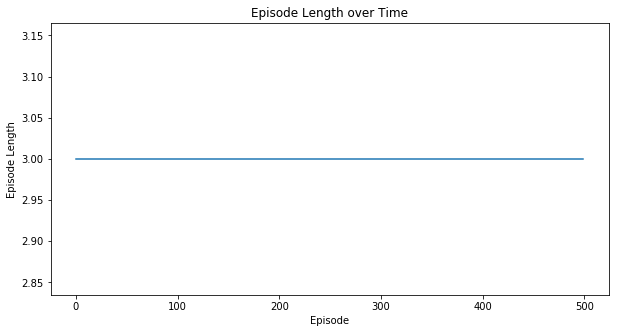

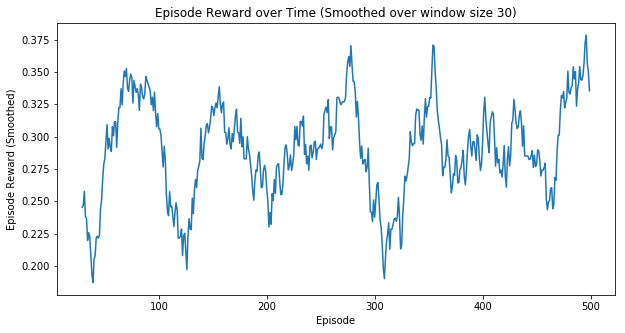

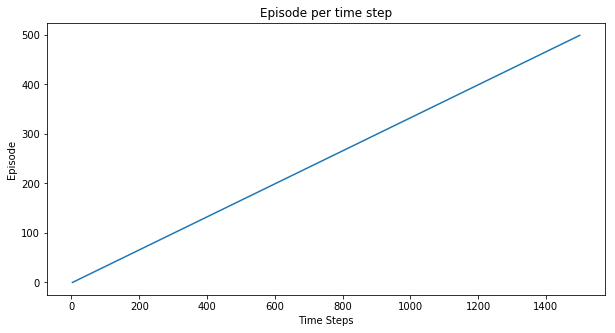

(<matplotlib.figure.Figure at 0x23e1da5f710>,
 <matplotlib.figure.Figure at 0x23e1134ccf8>)

In [119]:
plotting.plot_episode_stats(stats, smoothing_window=30)

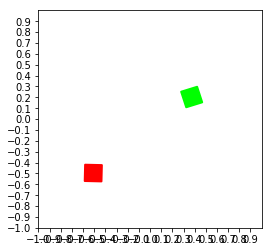

(None, None)
[0.13462969 0.12740303 0.30702688]
[[ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.   0.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.   0.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.   0.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.   0.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0. ]]
Progress = 0.01; reward = 0.01


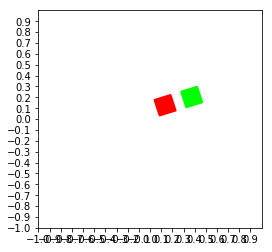

(None, None)
[-0.29287061  0.54820993  0.30702688]
[[ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]]
Progress = 0.65; reward = 0.66


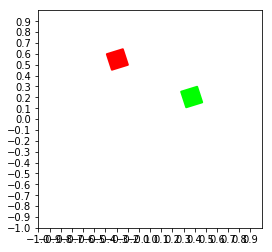

(None, None)
[-0.07093415  0.43312646  0.30702688]
[[ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -2.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   2.   1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]]
Progress = 0.42; reward = -0.18


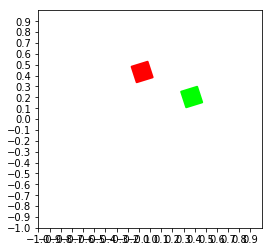

(None, None)
[-0.29287061  0.54820993  0.30702688]
[[ 0.   0.   0.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -2.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   1.   0.   0.   0.   0. ]
 [ 0.   2.   1.   0.   0.   0.   0. ]]
Progress = 0.50; reward = -0.03


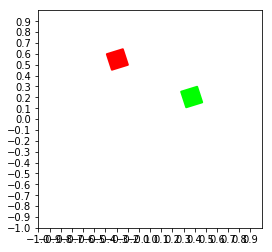

(None, None)
[0.22182583 0.67957767 0.30702688]
[[ 0.  -2.  -1.   0.   0.   0.  -0.5]
 [ 0.  -2.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   2.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   2.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -2.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   2.   1.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]]
Progress = 0.34; reward = -0.06


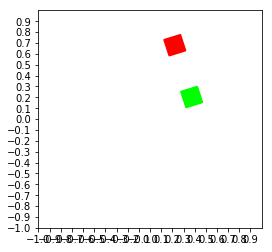

In [103]:
past_envs[0].env.replay(verbose = True)

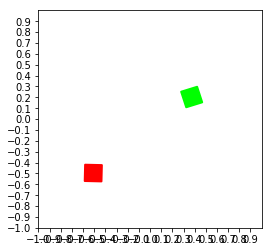

(None, None)
[0.13462969 0.12740303 0.30702688]
[[ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.   0.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.   0.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.   0.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.   0.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0. ]]
Progress = 0.00; reward = 0.01


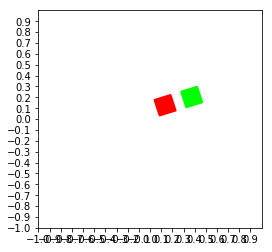

(None, None)
[-0.29287061  0.54820993  0.30702688]
[[ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]]
Progress = 0.63; reward = 0.62


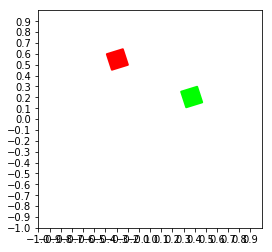

(None, None)
[-0.07093415  0.43312646  0.30702688]
[[ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -2.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   2.   1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]]
Progress = 0.49; reward = -0.19


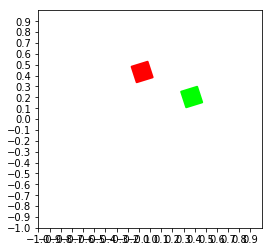

(None, None)
[-0.29287061  0.54820993  0.30702688]
[[ 0.   0.   0.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -2.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   1.   0.   0.   0.   0. ]
 [ 0.   2.   1.   0.   0.   0.   0. ]]
Progress = 0.53; reward = 0.04


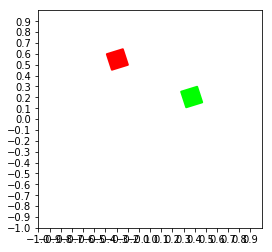

(None, None)
[0.22182583 0.67957767 0.30702688]
[[ 0.  -2.  -1.   0.   0.   0.  -0.5]
 [ 0.  -2.  -1.   0.   0.   0.   1. ]
 [ 0.  -1.  -1.   0.   0.   0.   1. ]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   2.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   2.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -2.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   2.   1.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]]
Progress = 0.40; reward = -0.14


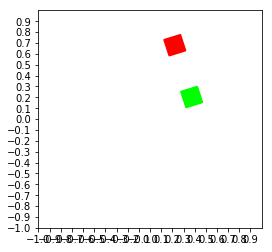

In [104]:
past_envs[0].env.replay(verbose = True)

In [121]:
reload(block_movement_env)
bme = block_movement_env.BlockMovementEnv(c, projects['SlideAround'].speed, projects['SlideAround'].name, 
                progress_estimator = progress_estimators['SlideAround'], session = sess)

In [122]:
bme.default()

array([-0.71322928, -0.68750558,  0.5       , -0.71322928, -0.68750558,
        0.5       , -0.2344808 , -0.16797299,  0.6       , -0.2344808 ,
       -0.16797299,  0.6       ])

In [123]:
bme.default_action()

[-0.75, 0.5, 0.5]
current_progress [0.5431167  0.6173226  0.6489324  0.5406632  0.5785468  0.68388045
 0.58182746 0.6143872  0.57749784 0.5607817  0.64790785 0.66864055
 0.59738624 0.61401385 0.58485615 0.62052125 0.5074123  0.59270275
 0.6513327  0.6816108  0.600791   0.56661236 0.5694105  0.61490023
 0.6511519  0.56448984 0.64235157 0.5760233  0.61403257 0.6263474 ]
current_progress [0.653854   0.6854157  0.63906837 0.5857317  0.641102   0.579031
 0.63019085 0.59618425 0.5743467  0.65067214 0.56983286 0.57359487
 0.60286003 0.64332104 0.5618652  0.57984984 0.5829447  0.64215755
 0.5708115  0.6716967  0.61899453 0.66414255 0.6497939  0.65127546
 0.5709444  0.6343916  0.5943038  0.5916542  0.5851231  0.6622229 ]
[-0.75, 0.5, 0.5]
current_progress [0.692314   0.54924977 0.6465387  0.61870503 0.6240257  0.6529374
 0.596472   0.62164783 0.60270894 0.64442843 0.5949359  0.61891264
 0.6950314  0.61680925 0.56492954 0.59353596 0.6530193  0.5786282
 0.6526831  0.61992025 0.5958283  0.61107653

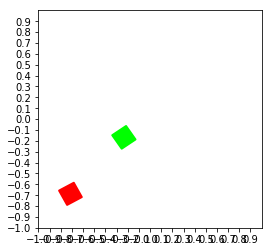

(None, None)
[-0.75  0.5   0.5 ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]]
Progress = 0.56; reward = 0.59


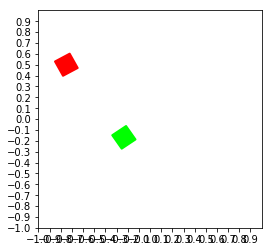

(None, None)
[-0.75  0.5   0.5 ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]]
Progress = 0.57; reward = 0.03


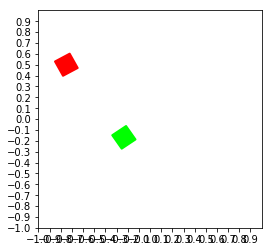

(None, None)
[-0.3   0.55  0.5 ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [-1.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]]
Progress = 0.55; reward = -0.09


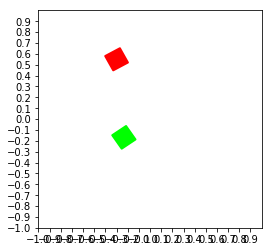

In [120]:
bme.replay(verbose = True)